100%|██████████| 170498071/170498071 [00:03<00:00, 52874187.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<ipython-input-1-612f38dc833e>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  x_train = torch.Tensor([np.array(image) for image, _ in train_data])


Epoch 1/30 | Train Loss: 2.1098 | Train Acc: 34.95% | Val Loss: 2.0434 | Val Acc: 41.67%
Epoch 2/30 | Train Loss: 2.0292 | Train Acc: 42.98% | Val Loss: 2.0287 | Val Acc: 42.93%
Epoch 3/30 | Train Loss: 1.9972 | Train Acc: 46.22% | Val Loss: 2.0053 | Val Acc: 45.25%
Epoch 4/30 | Train Loss: 1.9744 | Train Acc: 48.60% | Val Loss: 1.9923 | Val Acc: 46.70%
Epoch 5/30 | Train Loss: 1.9549 | Train Acc: 50.68% | Val Loss: 1.9790 | Val Acc: 47.99%
Epoch 6/30 | Train Loss: 1.9381 | Train Acc: 52.33% | Val Loss: 1.9709 | Val Acc: 49.00%
Epoch 7/30 | Train Loss: 1.9214 | Train Acc: 54.19% | Val Loss: 1.9660 | Val Acc: 49.11%
Epoch 8/30 | Train Loss: 1.9071 | Train Acc: 55.62% | Val Loss: 1.9641 | Val Acc: 49.16%
Epoch 9/30 | Train Loss: 1.8953 | Train Acc: 56.79% | Val Loss: 1.9538 | Val Acc: 50.42%
Epoch 10/30 | Train Loss: 1.8834 | Train Acc: 57.95% | Val Loss: 1.9468 | Val Acc: 51.11%
Epoch 11/30 | Train Loss: 1.8701 | Train Acc: 59.37% | Val Loss: 1.9468 | Val Acc: 51.23%
Epoch 12/30 | Train

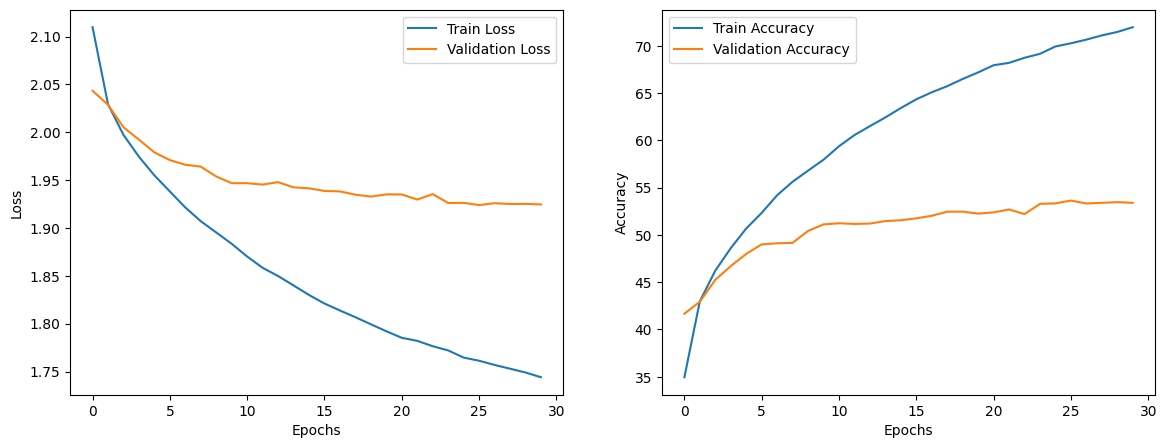

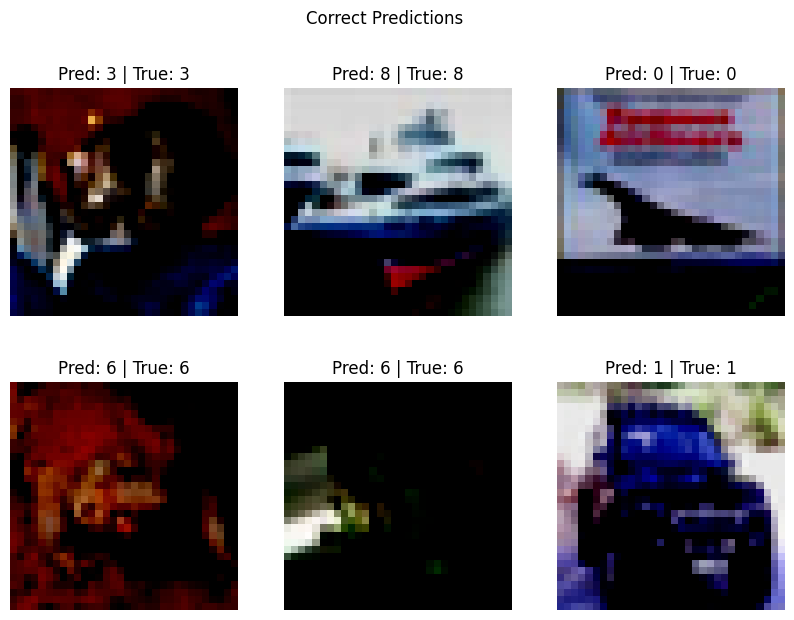

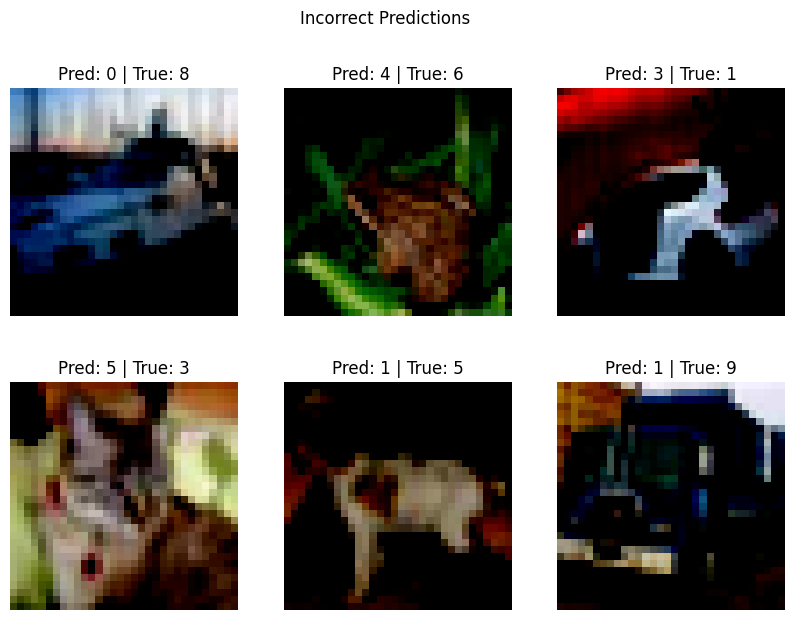

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
import torchvision
from torchvision import transforms

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

x_train = torch.Tensor([np.array(image) for image, _ in train_data])
y_train = torch.Tensor([label for _, label in train_data]).long()

x_test = torch.Tensor([np.array(image) for image, _ in test_data])
y_test = torch.Tensor([label for _, label in test_data]).long()

n_classes = 10

# Define the Autoencoder Classifier model
class AutoencoderClassifier(nn.Module):
    def __init__(self, input_shape, output_shape, z_dim):
        super(AutoencoderClassifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, z_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(z_dim, output_shape),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.classifier(z)

# Hyperparameters
z_dim  = 256
epochs = 30
batch_size = 128
learning_rate = 1e-4

# Initialize the model
input_shape = 3 * 32 * 32
output_shape = n_classes

model = AutoencoderClassifier(input_shape, output_shape, z_dim).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader
train_dataset = data_utils.TensorDataset(x_train.view(-1, input_shape), y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = data_utils.TensorDataset(x_test.view(-1, input_shape), y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(100. * correct / total)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

    val_losses.append(val_loss / len(test_dataloader))
    val_accuracies.append(100. * correct / total)

    print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | '
          f'Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%')

# Plotting Loss and Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Visualizing Correct and Incorrect Predictions
model.eval()
correct_preds = []
incorrect_preds = []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predicted = outputs.max(1)

        for i in range(X.size(0)):
            if predicted[i] == y[i]:
                correct_preds.append((X[i], predicted[i].item(), y[i].item()))
            else:
                incorrect_preds.append((X[i], predicted[i].item(), y[i].item()))

# Plot Correct Predictions
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.suptitle('Correct Predictions')

for i, ax in enumerate(axes.flatten()):
    img = correct_preds[i][0].cpu().view(3, 32, 32)
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.set_title(f'Pred: {correct_preds[i][1]} | True: {correct_preds[i][2]}')
    ax.axis('off')

plt.show()

# Plot Incorrect Predictions
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.suptitle('Incorrect Predictions')

for i, ax in enumerate(axes.flatten()):
    img = incorrect_preds[i][0].cpu().view(3, 32, 32)
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.set_title(f'Pred: {incorrect_preds[i][1]} | True: {incorrect_preds[i][2]}')
    ax.axis('off')

plt.show()
